# Parallel processing in NaaVRE workflows

## “Batch” splitting for processing a larger number of items

When processing a larger number of items, we cannot create an instance for each item when running the workflow. When a workflow creates more instances than what the computing resources allow for, some instances may be terminated and the workflow fails. Even if instances are not terminated, they won't run in parallel. Instead, the workflow engine will wait for some instances to finish before starting new ones. This creates significant overhead, where containers are constantly created and destroyed, only to process a single item. 

To avoid the above, the strategy is to split the list of items into $m$ batches, and to create an instance for each batch. The example below expands on the “classic” splitting approach ([splitting-classic.ipynb](./splitting-classic.ipynb)).

- Cell 1 generates a list of $n$ items, and splits it into $m$ batches. This creates a nested list of items.
- Cell 2 iterates over the batches, and over items within a batch, saving the result in a new nested list of items. 
- Cell 3 consumes the processed batches

In the *notebook context*, items are processed sequentially in cell 2.

In the *workflow context*, we can introduce a splitter and a merger around cell 2. 

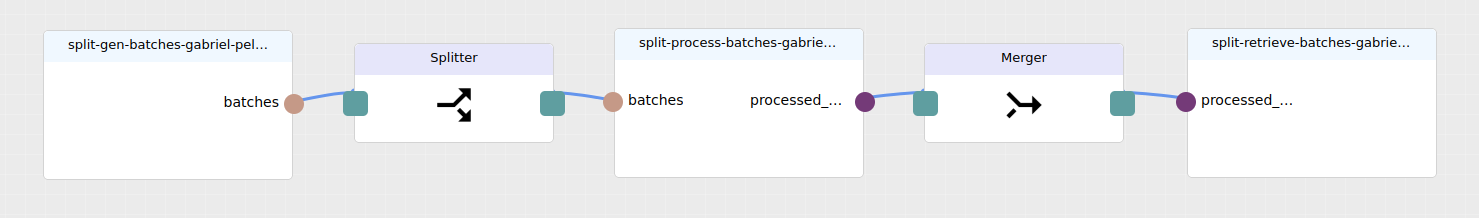

As a result, $n$ instances of cell 2 are created. Each instance processes a single item. Instances run in parallel.  

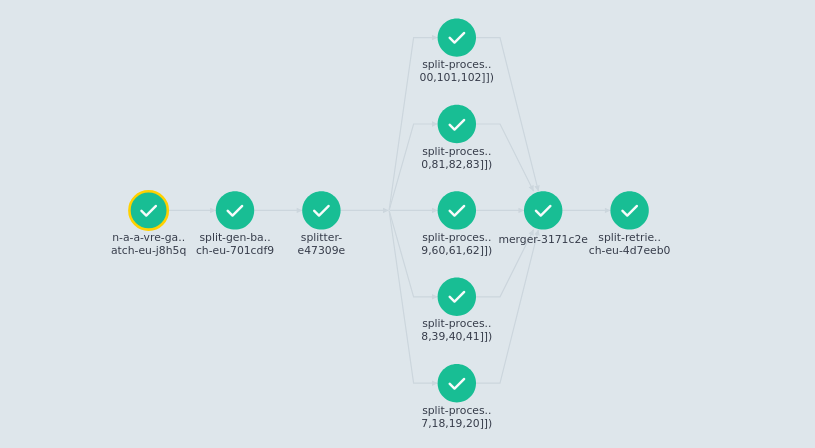

The topology is identical to that of the “classic” splitting example. However, with the current approach, cell 2 processes a list of batches instead of a list of items.  
The batching is done at the end of Cell 1, and undone at the end of cell 3.
As a result, the splitter receives a list of $m$ batches (example `[[0, 1], [2, 3], [4]]`) and splits it $m$ lists one batch (example `[[0, 1]]`, `[[2, 3]]`, and  `[[4]]`). Conversely, the merger merges $m$ lists of one batch into a list of $m$ batches. 

### Cell 0: Workflow parameters

In [1]:
# (do not containerize!)
param_item_count = 28
param_max_batch_count = 5

### Cell 1: generate a list of batches

This cell creates a list of $m$ batches, each containing up to $n/m+1$ items. It works the same in the notebook and workflow contexts.  
Example output: `[[0, 1], [2, 3], [4]]`

In [2]:
# split: gen batches

# your code to generate the items to be processed
items = list(range(param_item_count))
print(f'Generated items: {items}')

# group items into batches
def batch_items(items, max_batch_count) -> list:
    if len(items) == 0:
        return [[]]
    batch_size = len(items) // max_batch_count + bool(len(items) % max_batch_count)
    return [items[i:i+batch_size] for i in range(0, len(items), batch_size)]
batches = batch_items(items, param_max_batch_count)
print(f'Item batches: {batches}')

Generated items: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Item batches: [[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17], [18, 19, 20, 21, 22, 23], [24, 25, 26, 27]]


### Cell 2: process a list of batches

This list iteratively processes a list of item batches. The list contains $m$ batches in the *notebook context*, and $1$ batch in the *workflow context*. Batches contain up to $n/m+1$ items.

Example in the *notebook context*:

|        | notebook                                      |
|--------|:----------------------------------------------|
| input  | `[[0, 1], [2, 3], [4]]`                       |
| output | `[[0.0, 0.0238], [0.0476, 0.0714], [0.0952]]` |

Example in the *workflow context*:

|        | cell 1            | cell 2               | cell 3       |
|--------|:------------------|:---------------------|:-------------|
| input  | `[[0, 1]]`        | `[[2, 3]]`           | `[[4]]`      |
| output | `[[0.0, 0.0238]]` | `[[0.0476, 0.0714]]` | `[[0.0952]]` |


In [3]:
# split: process batches

# your code to process an individual item
def process_item(item):
    # print(f'Processing item {item}')
    return item / 42

# iteratively process all items
print(f'Batches to process: {batches}')
processed_batches = []
for batch in batches:
    processed_batch = []
    for item in batch:
        processed_batch.append(process_item(item))
    processed_batches.append(processed_batch)
print(f'Processed batches: {processed_batches}')

Batches to process: [[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17], [18, 19, 20, 21, 22, 23], [24, 25, 26, 27]]
Processed batches: [[0.0, 0.023809523809523808, 0.047619047619047616, 0.07142857142857142, 0.09523809523809523, 0.11904761904761904], [0.14285714285714285, 0.16666666666666666, 0.19047619047619047, 0.21428571428571427, 0.23809523809523808, 0.2619047619047619], [0.2857142857142857, 0.30952380952380953, 0.3333333333333333, 0.35714285714285715, 0.38095238095238093, 0.40476190476190477], [0.42857142857142855, 0.4523809523809524, 0.47619047619047616, 0.5, 0.5238095238095238, 0.5476190476190477], [0.5714285714285714, 0.5952380952380952, 0.6190476190476191, 0.6428571428571429]]


### Cell 3: consume a list of generated batches

Example input: `[[0.0, 0.0238], [0.0476, 0.0714], [0.0952]]`

In [4]:
# split: retrieve batches
print(f'Processed batches: {processed_batches}')

# Transform the batches back into a single list
from itertools import chain
processed_items = list(chain(*processed_batches))
print(f'Processed items: {processed_items}')

Processed batches: [[0.0, 0.023809523809523808, 0.047619047619047616, 0.07142857142857142, 0.09523809523809523, 0.11904761904761904], [0.14285714285714285, 0.16666666666666666, 0.19047619047619047, 0.21428571428571427, 0.23809523809523808, 0.2619047619047619], [0.2857142857142857, 0.30952380952380953, 0.3333333333333333, 0.35714285714285715, 0.38095238095238093, 0.40476190476190477], [0.42857142857142855, 0.4523809523809524, 0.47619047619047616, 0.5, 0.5238095238095238, 0.5476190476190477], [0.5714285714285714, 0.5952380952380952, 0.6190476190476191, 0.6428571428571429]]
Processed items: [0.0, 0.023809523809523808, 0.047619047619047616, 0.07142857142857142, 0.09523809523809523, 0.11904761904761904, 0.14285714285714285, 0.16666666666666666, 0.19047619047619047, 0.21428571428571427, 0.23809523809523808, 0.2619047619047619, 0.2857142857142857, 0.30952380952380953, 0.3333333333333333, 0.35714285714285715, 0.38095238095238093, 0.40476190476190477, 0.42857142857142855, 0.4523809523809524, 0.